<a href="https://colab.research.google.com/github/arriagajorge/regularization-linearmodel/blob/main/Tarea_5ej9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
install.packages("ISLR2")
install.packages("glmnet")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘iterators’, ‘foreach’, ‘shape’, ‘Rcpp’, ‘RcppEigen’




In [20]:
install.packages("pbapply")
library(pbapply)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
library(ISLR2)
library(glmnet)

In [4]:
data("College")
head(College, 2)
str(College)
n <- dim(College)[1]
sum(is.na.data.frame(College)) #no hay NA's

#ajuste lm
lm_simple <- lm(Apps ~ ., data=College)
lm_2 <- lm(Apps ~ .^2, data=College)
lm_2_stepAIC <- step(lm_2, k=2)
lm_2_stepBIC <- step(lm_2, k=log(n))

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56


'data.frame':	777 obs. of  18 variables:
 $ Private    : Factor w/ 2 levels "No","Yes": 2 2 2 2 2 2 2 2 2 2 ...
 $ Apps       : num  1660 2186 1428 417 193 ...
 $ Accept     : num  1232 1924 1097 349 146 ...
 $ Enroll     : num  721 512 336 137 55 158 103 489 227 172 ...
 $ Top10perc  : num  23 16 22 60 16 38 17 37 30 21 ...
 $ Top25perc  : num  52 29 50 89 44 62 45 68 63 44 ...
 $ F.Undergrad: num  2885 2683 1036 510 249 ...
 $ P.Undergrad: num  537 1227 99 63 869 ...
 $ Outstate   : num  7440 12280 11250 12960 7560 ...
 $ Room.Board : num  3300 6450 3750 5450 4120 ...
 $ Books      : num  450 750 400 450 800 500 500 450 300 660 ...
 $ Personal   : num  2200 1500 1165 875 1500 ...
 $ PhD        : num  70 29 53 92 76 67 90 89 79 40 ...
 $ Terminal   : num  78 30 66 97 72 73 93 100 84 41 ...
 $ S.F.Ratio  : num  18.1 12.2 12.9 7.7 11.9 9.4 11.5 13.7 11.3 11.5 ...
 $ perc.alumni: num  12 16 30 37 2 11 26 37 23 15 ...
 $ Expend     : num  7041 10527 8735 19016 10922 ...
 $ Grad.Rate  : nu

[1] 0

Se han truncado las últimas 5000 líneas del flujo de salida.
- Personal:Expend          1   1918927 277760425 10634
- Private:Terminal         1   2059885 277901383 10635
- P.Undergrad:Books        1   2078625 277920123 10635
- P.Undergrad:S.F.Ratio    1   2192747 278034245 10635
- Top25perc:S.F.Ratio      1   2242868 278084366 10635
<none>                                 275841498 10636
- Top10perc:Terminal       1   2405589 278247087 10636
- Outstate:S.F.Ratio       1   2408349 278249847 10636
- Private:S.F.Ratio        1   2574954 278416452 10636
- Enroll:Top25perc         1   2683211 278524709 10636
- Top10perc:Outstate       1   2758321 278599819 10636
- P.Undergrad:Terminal     1   2802393 278643891 10637
- P.Undergrad:Personal     1   3209151 279050649 10638
- Accept:Books             1   3428851 279270349 10638
- F.Undergrad:Room.Board   1   3636557 279478055 10639
- Top10perc:PhD            1   3700016 279541514 10639
- F.Undergrad:Outstate     1   3871700 279713198 10640
- To

In [5]:
#r2_adj
summary(lm_simple)$adj.r.squared        #0.927
summary(lm_2)$adj.r.squared             #0.970
summary(lm_2_stepAIC)$adj.r.squared     #0.972
summary(lm_2_stepBIC)$adj.r.squared     #0.969

#no predictores
length(lm_simple$coefficients)-1         #17
length(lm_2$coefficients)-1              #153
length(lm_2_stepAIC$coefficients)-1      #87
length(lm_2_stepBIC$coefficients)-1      #46

[1] 0.9276027

[1] 0.9707533

[1] 0.9726046

[1] 0.9699771

[1] 17

[1] 153

[1] 87

[1] 46

In [6]:
#errores aparentes ECM
ecm_lm <- function(model){
  return(mean(model$residuals^2))
}
ecm_lm(lm_simple)                       #1059279
ecm_lm(lm_2)                            #351245.2 #best
ecm_lm(lm_2_stepAIC)                    #363867.4
ecm_lm(lm_2_stepBIC)                    #422495.7

[1] 1059279

[1] 351245.2

[1] 363867.4

[1] 422495.7

In [7]:
# Errores de prueba
# función que calcula el error de prueba con B = 1
ECM_test <- function(model, ntrain){ #ntrain = número de elementos de la muestra de entrenamiento
  train <- sample(1:n, ntrain)
  p <- predict(lm(model$call$formula, College[train,]), newdata = College[-train,])
  return(mean((p - College[-train, "Apps"])^2))
}
# función que calcula el error de prueba B-veces
ECM_test_B <- function(model, B, ntrain){
  return(replicate(B, ECM_test(model, ntrain)))
}

In [8]:
t0 = proc.time()
set.seed(11)  #1297676
mean(ECM_test_B(model = lm_simple, B = 2000, ntrain = round(0.75*n))) 

set.seed(11)  #2043517
mean(ECM_test_B(model = lm_2, B = 2000, ntrain = round(0.75*n)))

set.seed(11)  #970122.7
mean(ECM_test_B(model = lm_2_stepAIC, B = 2000, ntrain = round(0.75*n)))

set.seed(11)  #793949.2 #best
mean(ECM_test_B(model = lm_2_stepBIC, B = 2000, ntrain = round(0.75*n)))
proc.time() - t0  
# user  system elapsed  
#85.44    0.69   86.64   acer intel i5 (12 GB ram)
#60.891   0.112  61.110  Google Colab (Some power)

[1] 1297676

[1] 2043517

[1] 970122.7

[1] 793949.2

   user  system elapsed 
 60.891   0.112  61.110 

## RIDGE REGRESSION

In [13]:
x <- model.matrix(Apps~.^2, College)[, -1] #input matrix, of dimension nobs x nvars
y <- College$Apps #response variable

In [14]:
# trabajaremos con el modelo step(lm ~ .^2, k=log(n))
ridgemod <- glmnet(x, y, alpha = 0) #esto solo es para conseguir los valores de lambda
val_lambda <- ridgemod$lambda

In [18]:
#función para calcular error de prueba para un valor de lambda UNA SOLA VEZ
ntrain <- round(0.75*n)
test_lambda_RR <- function(lambda){
  train <- sample(1:n, ntrain)
  ridge_mod <- glmnet(x[train,], y[train], alpha = 0)
  ridge_pred <- predict(ridge_mod, s = lambda, newx = x[-train, ])
  return(mean((ridge_pred - y[-train])^2))
}
#función para calcular error de prueba para valores de lambda UNA SOLA VEZ
test_lambda_RR_VEC <- Vectorize(test_lambda_RR)
#función para calcular error de prueba para valores de lambda B-VECES
test_lambda_RR_B <- function(lambda, B){
  return(replicate(B, test_lambda_RR_VEC(lambda)))
}

In [19]:
set.seed(11)
t0 <- proc.time()
lamdas_test <- test_lambda_RR_B(lambda = val_lambda, B = 1000)
proc.time() - t0 
#    user   system  elapsed  Google colab (Many power)
#3003.269    4.894 3013.140 

    user   system  elapsed 
3003.269    4.894 3013.140 

In [21]:
mean_test_lambda_RR <- apply(lamdas_test, 1, mean)
wmin_RR <- which.min(mean_test_lambda_RR)
print(min(mean_test_lambda_RR)) #1124391
print(val_lambda[wmin_RR])      #366.6069

[1] 1124391
[1] 366.6069


In [23]:
mean(test_lambda_RR_B(val_lambda[wmin_RR], 2000)) #1134595.74304808

[1] 1134596

In [54]:
#error aparente RIDGE REGRESSION
ridge_mod_ap <- glmnet(x, y, alpha = 0)
ridge_pred_ap <- predict(ridge_mod_ap, s = val_lambda[wmin_RR], newx = x)
print(mean((ridge_pred_ap - y)^2))

[1] 659201.2


## LASSO

In [24]:
lassomod <- glmnet(x, y, alpha = 1) #esto solo es para conseguir los valores de lambda
val_lambda_lasso <- lassomod$lambda

In [25]:
#función para calcular error de prueba para un valor de lambda UNA SOLA VEZ
ntrain <- round(0.75*n)
test_lambda_lasso <- function(lambda){
  train <- sample(1:n, ntrain)
  lasso_mod <- glmnet(x[train,], y[train], alpha = 1)
  lasso_pred <- predict(lasso_mod, s = lambda, newx = x[-train, ])
  return(mean((lasso_pred - y[-train])^2))
}
#función para calcular error de prueba para valores de lambda UNA SOLA VEZ
test_lambda_lasso_VEC <- Vectorize(test_lambda_lasso)
#función para calcular error de prueba para valores de lambda B-VECES
test_lambda_lasso_B <- function(lambda, B){
  return(replicate(B, test_lambda_lasso_VEC(lambda)))
}

In [26]:
set.seed(11)
t0 <- proc.time()
lambdas_test_lasso <- test_lambda_RR_B(lambda = val_lambda_lasso, B = 1000)
proc.time() - t0 
#     user   system  elapsed 
# 3001.247    6.505 3012.716

    user   system  elapsed 
3001.247    6.505 3012.716 

In [28]:
mean_test_lambda_lasso <- apply(lambdas_test_lasso, 1, mean)
wmin_lasso <- which.min(mean_test_lambda_lasso)
print(min(mean_test_lambda_lasso)) #1083800
print(val_lambda_lasso[wmin_lasso]) #20.02509

[1] 1083800
[1] 20.02509


In [30]:
mean(test_lambda_lasso_B(val_lambda_lasso[wmin_lasso], 2000))

[1] 1076348

In [47]:
out <- glmnet (x, y, alpha = 1)
lasso_coef <-  predict(out , type = "coefficients", s = val_lambda_lasso[wmin_lasso])
print(length(lasso_coef))

[1] 154


In [53]:
print(length(lasso_coef[lasso_coef != 0 ]))
lasso_coef

<sparse>[ <logic> ] : .M.sub.i.logical() maybe inefficient



[1] 33


154 x 1 sparse Matrix of class "dgCMatrix"
                                   s1
(Intercept)              5.994790e+02
PrivateYes               .           
Accept                   4.102414e-02
Enroll                   .           
Top10perc                .           
Top25perc                .           
F.Undergrad              .           
P.Undergrad              .           
Outstate                 .           
Room.Board               .           
Books                    .           
Personal                 .           
PhD                      .           
Terminal                 .           
S.F.Ratio                3.034719e-01
perc.alumni              .           
Expend                   .           
Grad.Rate               -3.882493e+00
PrivateYes:Accept       -1.745478e-01
PrivateYes:Enroll        4.497135e-01
PrivateYes:Top10perc     .           
PrivateYes:Top25perc    -3.292834e+00
PrivateYes:F.Undergrad   .           
PrivateYes:P.Undergrad   .           
Private

In [56]:
#error aparente LASSO
lasso_mod_ap <- glmnet(x, y, alpha = 1)
lasso_pred_ap <- predict(lasso_mod_ap, s = val_lambda_lasso[wmin_lasso], newx = x)
print(mean((lasso_pred_ap - y)^2))

[1] 651318.2


## PCR

In [59]:
install.packages("pls")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [60]:
library(pls)


Attaching package: ‘pls’


The following object is masked from ‘package:stats’:

    loadings




In [139]:
summary(prcomp(College[,-c(2,1)], scale= T))

Importance of components:
                          PC1    PC2     PC3     PC4    PC5     PC6     PC7
Standard deviation     2.2898 1.9721 1.08153 0.96602 0.9584 0.92026 0.77723
Proportion of Variance 0.3277 0.2431 0.07311 0.05832 0.0574 0.05293 0.03776
Cumulative Proportion  0.3277 0.5707 0.64386 0.70219 0.7596 0.81252 0.85028
                           PC8     PC9    PC10    PC11    PC12    PC13    PC14
Standard deviation     0.76132 0.72389 0.63446 0.55903 0.46932 0.37991 0.32171
Proportion of Variance 0.03623 0.03275 0.02516 0.01953 0.01377 0.00902 0.00647
Cumulative Proportion  0.88650 0.91925 0.94441 0.96394 0.97771 0.98673 0.99320
                          PC15    PC16
Standard deviation     0.28463 0.16674
Proportion of Variance 0.00506 0.00174
Cumulative Proportion  0.99826 1.00000

In [140]:
pcr_fit <- pcr(Apps ~ ., data = College, subset = sample(1:n, ntrain), scale = TRUE, validation = "none")
summary(pcr_fit)

Data: 	X dimension: 583 17 
	Y dimension: 583 1
Fit method: svdpc
Number of components considered: 17
TRAINING: % variance explained
      1 comps  2 comps  3 comps  4 comps  5 comps  6 comps  7 comps  8 comps
X      31.704    57.74    64.82    70.43    75.58    80.65    84.31    87.66
Apps    1.325    72.38    72.47    75.92    83.02    83.66    84.27    84.71
      9 comps  10 comps  11 comps  12 comps  13 comps  14 comps  15 comps
X       90.66     92.98     95.07     96.84     97.89     98.71     99.34
Apps    85.55     85.84     86.01     86.02     86.15     86.27     90.33
      16 comps  17 comps
X        99.81    100.00
Apps     92.50     92.92


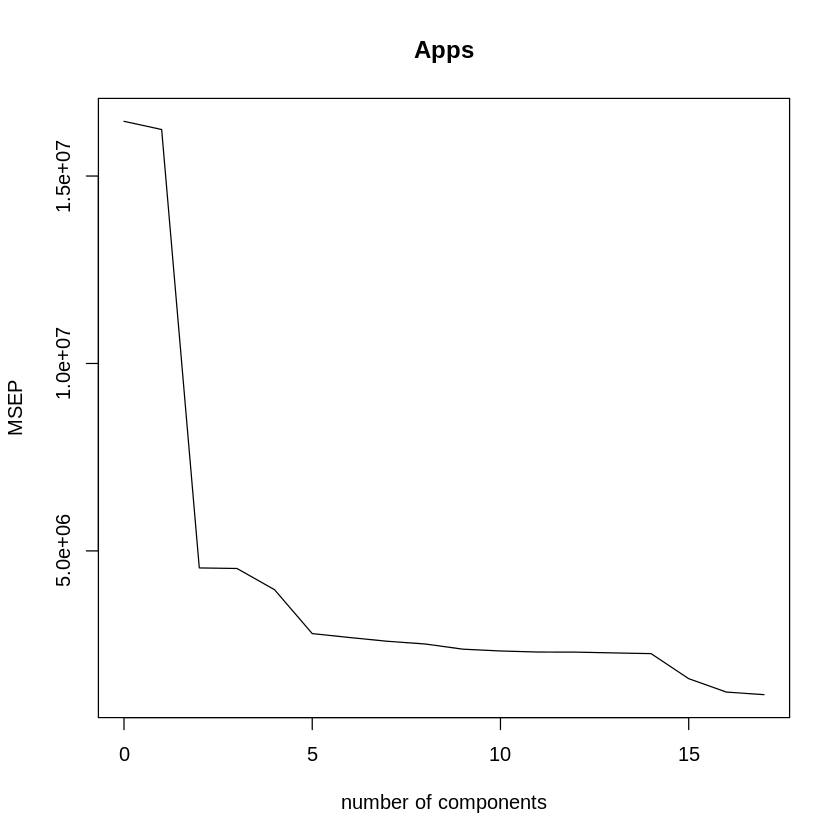

In [141]:
validationplot(pcr_fit , val.type = "MSEP")

In [129]:
# funcion que calcula error de prueba UNA vez para UN valor de M
test_M_pcr <- function(M){ # M representa el número de componentes principales en la regresión
  train <- sample(1:n, ntrain)
  pcr_fit <- pcr(Apps ~ ., data = College, subset = train, scale = TRUE, validation = "none")
  pcr_pred <- predict(pcr_fit , College[-train, ], ncomp = 5)
  return(mean((pcr_pred - y[-train])^2))
}
# funcion que calcula error de prueba UNA vez para VARIOS valor de M
test_M_pcr_VEC <- Vectorize(test_M_pcr)

In [130]:
# funcion que calcula error de prueba B-VECES para VARIOS valor de M
test_M_pcr_B <- function(M, B){
  return(replicate(B, test_M_pcr_VEC(M)))
}

In [135]:
set.seed(11)
t0 = proc.time()
test_M_2000 <- test_M_pcr_B(M=1:17, B=2000)
proc.time() - t0
#   user  system elapsed   Google-Colab (some power)
#306.327   1.443 308.396

   user  system elapsed 
306.327   1.443 308.396 

In [136]:
#error de prueba
mean_test_M <- apply(test_M_2000, 1, mean)
wminM <- which.min(mean_test_M)
print(wminM)          #10
min(mean_test_M)      #2553216.97400996

[1] 10


[1] 2553217